This notebook contains all the code needed to generate a synthetic dataset.

Exits and funding are pulled from lognormal distr
Ordinal founder attrs come from discrete pdfs in hyperparameter config.

All params handled in `src/config.py` `SYNTH` variable.

Visualizations provided at the end to compare with expectations of real-world data.

Defining success as an exit or `config.SUCCESS_THRESHOLD` in funding. compute a raw score (which could be used to prioritize) and probability of success in `model.ipynb`.

In [9]:
# ! pip install seaborn plotly scipy -q

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import sys
from pathlib import Path

sys.path.append("..")

from src.config.config import cfg
from src.datagen import datagen

In [11]:
MATRIX = cfg.MATRIX
POPULATIONS = cfg.SYNTH["POPULATIONS"]

K = sum(cfg["DIMENSION"] for cfg in MATRIX.values())

dg = datagen.DataGenerator(MATRIX)

### Generate dataset
Configure params in `src/config/config.SYNTH`

In [12]:
N = 1000
X_syn, exit_syn, fund_syn, pop_labels = dg.generate_dataset(N, POPULATIONS)

In [13]:
# viz tools
def get_category_slice(category_name):
    start = 0
    for cat in MATRIX:
        d = MATRIX[cat]["DIMENSION"]
        if cat == category_name:
            return slice(start, start + d)
        start += d
    return slice(0, 0)  # fallback


def plot_category_distribution_overall_and_by_pop(X, pop_labels, category_name):
    cat_slice = get_category_slice(category_name)
    d = MATRIX[category_name]["DIMENSION"]

    cat_indices = X[:, cat_slice].argmax(axis=1)  # 0..(d-1)

    counts = np.bincount(cat_indices, minlength=d)

    plt.figure(figsize=(8, 5))
    bars = plt.bar(range(d), counts, color="cornflowerblue", edgecolor="black")
    plt.title(f"Overall Distribution of {category_name} (tiers=0..{d-1})", fontsize=14)
    plt.xlabel("Tier Index", fontsize=12)
    plt.ylabel("Count", fontsize=12)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.5,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    unique_pops = np.unique(pop_labels)
    plt.figure(figsize=(10, 6))
    width = 0.8 / len(unique_pops)

    pop_percentages = {}
    for pop_name in unique_pops:
        pop_mask = pop_labels == pop_name
        cat_pop_indices = cat_indices[pop_mask]
        ccounts = np.bincount(cat_pop_indices, minlength=d)
        pop_percentages[pop_name] = 100.0 * ccounts / ccounts.sum()

    for i, pop_name in enumerate(unique_pops):
        pop_mask = pop_labels == pop_name
        x_positions = np.arange(d) + (i - len(unique_pops) / 2) * width + width / 2
        bars = plt.bar(
            x_positions,
            pop_percentages[pop_name],
            width=width,
            label=f"{pop_name} (n={pop_mask.sum()})",
        )

        for bar in bars:
            height = bar.get_height()
            if height > 5:
                plt.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height + 0.5,
                    f"{height:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    plt.title(f"{category_name} Tier Distribution by Population (%)", fontsize=14)
    plt.xlabel("Tier Index", fontsize=12)
    plt.ylabel("Percentage within Population", fontsize=12)
    plt.xticks(np.arange(d), [str(i) for i in range(d)])
    plt.legend(loc="best")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_hist_overall_and_by_pop(values, pop_labels, title, bins=50, log_scale=True):
    plt.figure(figsize=(10, 6))
    unique_pops = np.unique(pop_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_pops)))
    
    # Handle zeros and negatives for log scale
    min_nonzero = np.min(values[values > 0]) if np.any(values > 0) else 1
    plot_vals = values.copy()
    
    # Replace zeros/negatives with small value for log scale
    if log_scale:
        plot_vals[plot_vals <= 0] = min_nonzero * 0.1
        plot_vals = np.log10(plot_vals)
    
    xlabel_str = f"{title} {'(log10 scale)' if log_scale else ''}"
    
    for i, pop_name in enumerate(unique_pops):
        mask = pop_labels == pop_name
        sub_vals_raw = values[mask]
        sub_vals_log = plot_vals[mask]
        
        # Only compute KDE for non-zero/finite values
        nonzero_mask = np.isfinite(sub_vals_log) & (sub_vals_log > np.log10(min_nonzero * 0.1))
        if np.sum(nonzero_mask) > 1:
            sub_vals_nonzero = sub_vals_log[nonzero_mask]
            
            # Add small noise to prevent singular matrix
            sub_vals_nonzero = sub_vals_nonzero + np.random.normal(0, 1e-6, size=len(sub_vals_nonzero))
            
            kde = stats.gaussian_kde(sub_vals_nonzero)
            x_eval = np.linspace(sub_vals_nonzero.min(), sub_vals_nonzero.max(), 500)
            density = kde(x_eval)
            
            label_str = f"{pop_name} (mean={np.nanmean(sub_vals_raw):.2f})"
            plt.plot(x_eval, density, label=label_str, color=colors[i], linewidth=2)
            
            # Add point mass at zero if there are zeros
            if np.sum(~nonzero_mask) > 0:
                zero_prop = np.mean(~nonzero_mask)
                plt.vlines(np.log10(min_nonzero * 0.1), 0, zero_prop * np.max(density), 
                         color=colors[i], linestyles='--', alpha=0.5)

    plt.xlabel(xlabel_str, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"{title} Density by Population (KDE)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()





def plot_scatter_overall_and_by_pop(xvals, yvals, pop_labels, x_title, y_title, log_y=False):
    plt.figure(figsize=(10, 7))
    unique_pops = np.unique(pop_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_pops)))

    for i, pop_name in enumerate(unique_pops):
        mask = pop_labels == pop_name
        x_pop = xvals[mask]
        y_pop = yvals[mask]

        plt.scatter(x_pop, y_pop, alpha=0.5, label=pop_name, color=colors[i])

        if len(x_pop) > 3:
            if log_y:
                log_y_pop = np.log(y_pop)
                z = np.polyfit(x_pop, log_y_pop, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x_pop.min(), x_pop.max(), 50)
                plt.plot(
                    x_range,
                    np.exp(p(x_range)),
                    "--",
                    color=colors[i],
                    linewidth=2,
                    alpha=0.7,
                )
            else:
                z = np.polyfit(x_pop, y_pop, 1)
                p = np.poly1d(z)
                x_range = np.linspace(x_pop.min(), x_pop.max(), 50)
                plt.plot(x_range, p(x_range), "--", color=colors[i], linewidth=2, alpha=0.7)

    if log_y:
        plt.yscale("log")

    plt.xlim(left=0)

    plt.title(f"{x_title} vs. {y_title} by Population", fontsize=14)
    plt.xlabel(x_title, fontsize=12)
    plt.ylabel(y_title + (" [log scale]" if log_y else ""), fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(X, y, exit_vals, fund_vals, feature_names=None):
    if feature_names is None:
        feature_names = []
        for cat_name in MATRIX:
            d = MATRIX[cat_name]["DIMENSION"]
            for i in range(d):
                feature_names.append(f"{cat_name}_{i}")

    data = np.column_stack([X, y, exit_vals, fund_vals])
    col_names = feature_names + ["Score", "Exit", "Funding"]
    df = pd.DataFrame(data, columns=col_names)

    corr = df.corr()

    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        fmt=".2f",
    )
    plt.title("Correlation Heatmap: Features & Targets", fontsize=16)
    plt.tight_layout()
    plt.show()

    target_cols = ["Score", "Exit", "Funding"]
    target_corr = corr.loc[target_cols, target_cols]
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        target_corr,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        fmt=".2f",
    )
    plt.title("Correlation among Targets", fontsize=14)
    plt.tight_layout()
    plt.show()


def visualize_successful_cases(exit_vals, fund_vals, funding_threshold=None):
    if funding_threshold is None:
        funding_threshold = cfg.SUCCESS_FUNDING_THRESHOLD
        
    funding_success_mask = fund_vals > funding_threshold
    exit_success_mask = exit_vals > 0
    both_success_mask = funding_success_mask & exit_success_mask
    unsuccessful_mask = ~(funding_success_mask | exit_success_mask)
    

    num_funding_success = np.sum(funding_success_mask)
    num_exit_success = np.sum(exit_success_mask)
    num_both_success = np.sum(both_success_mask)
    num_unsuccessful = np.sum(unsuccessful_mask)


    # Plot
    categories = [f"Funding > ${funding_threshold}", "Exit > 0", "Both", "Unsuccessful"]
    counts = [num_funding_success, num_exit_success, num_both_success, num_unsuccessful]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, color=["teal", "orange", "purple", "grey"])
    plt.title("Number of Successful vs Unsuccessful Cases", fontsize=14)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Number of Cases", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

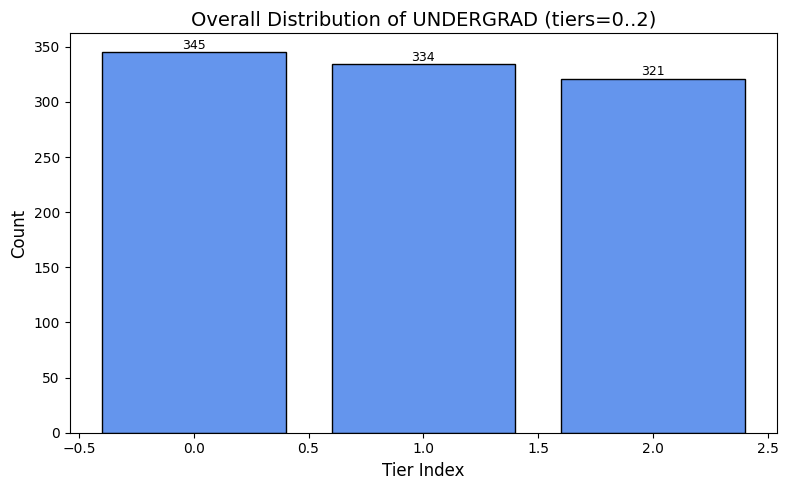

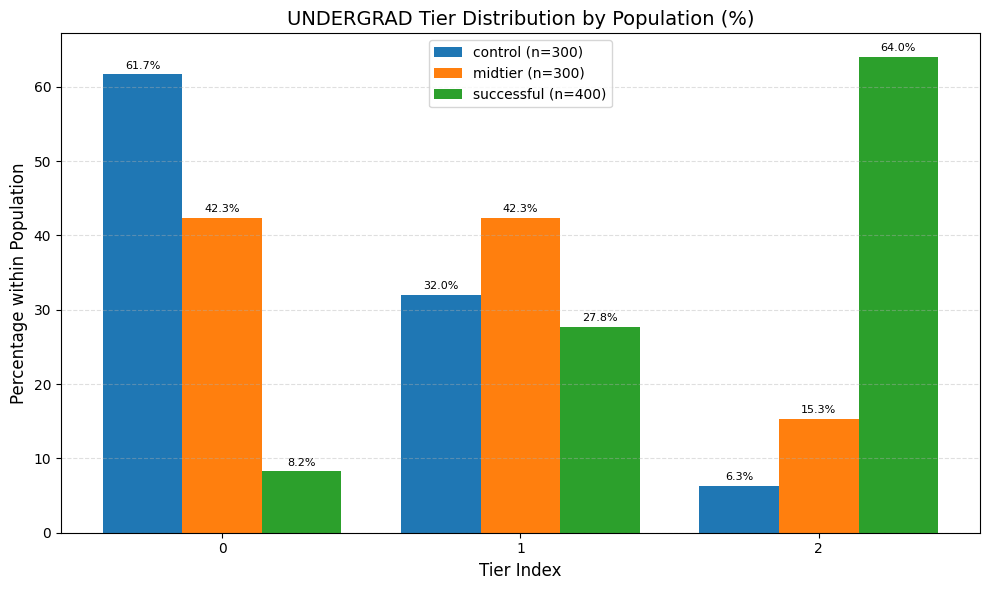

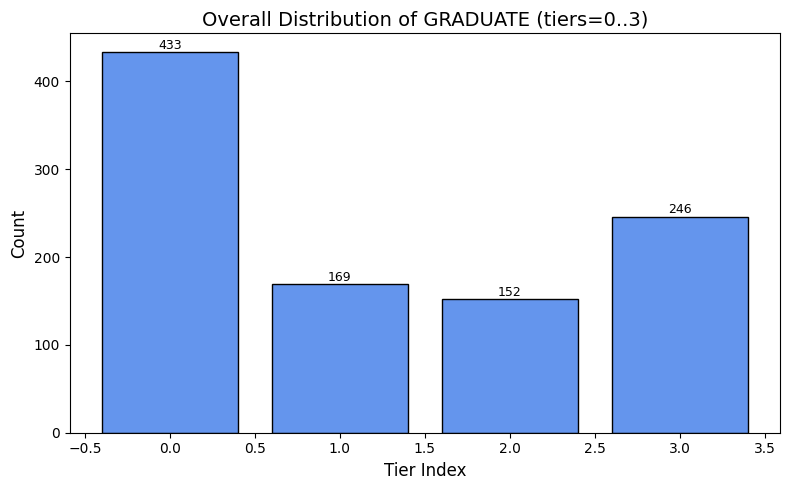

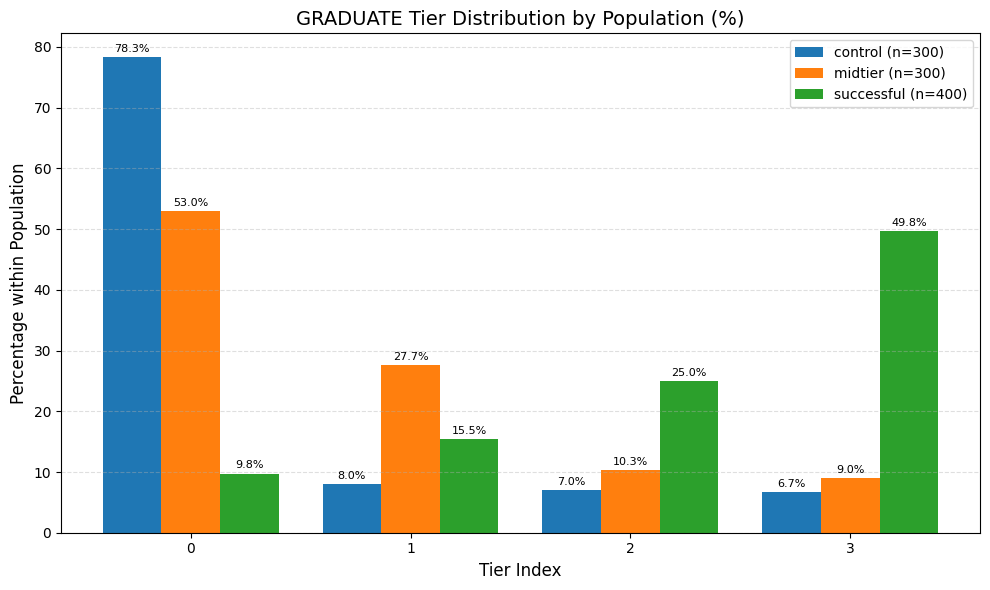

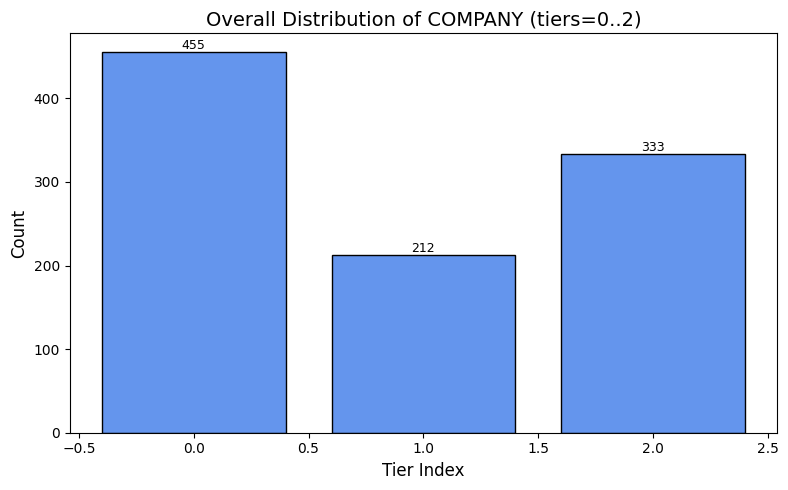

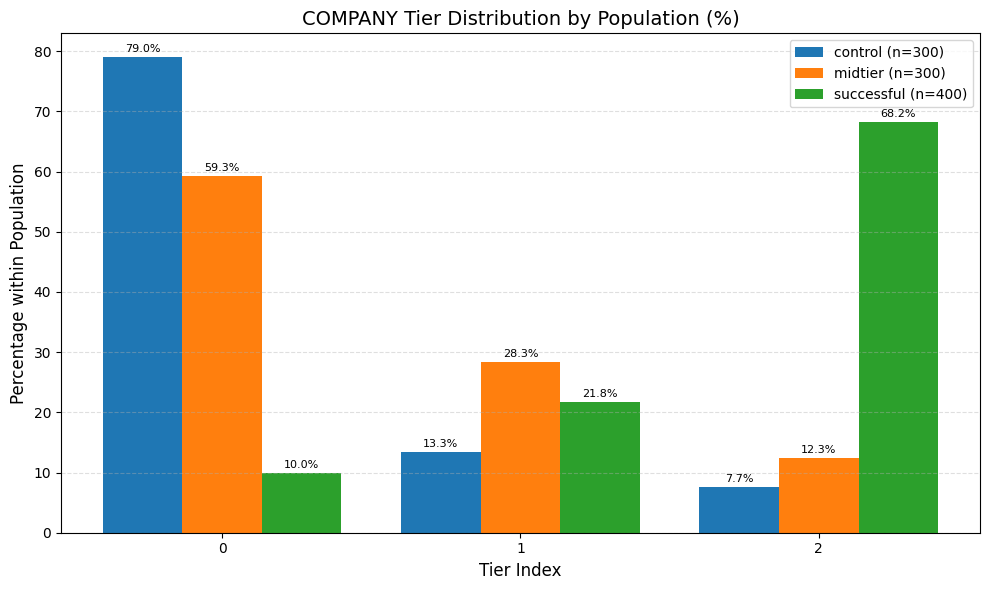

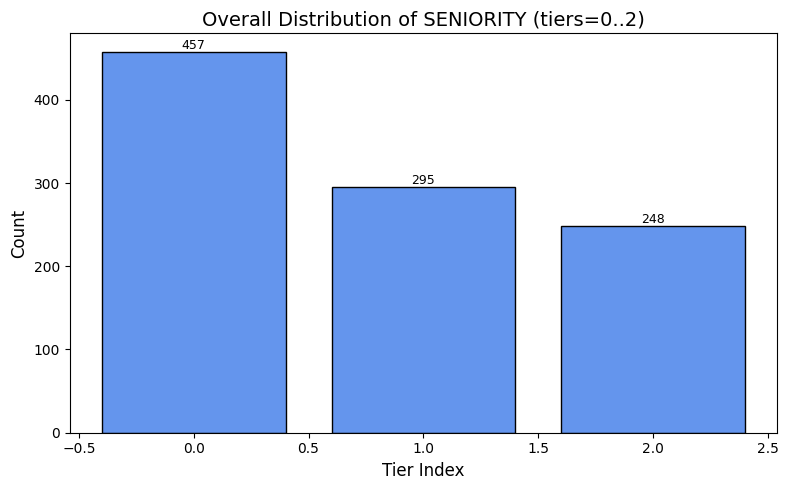

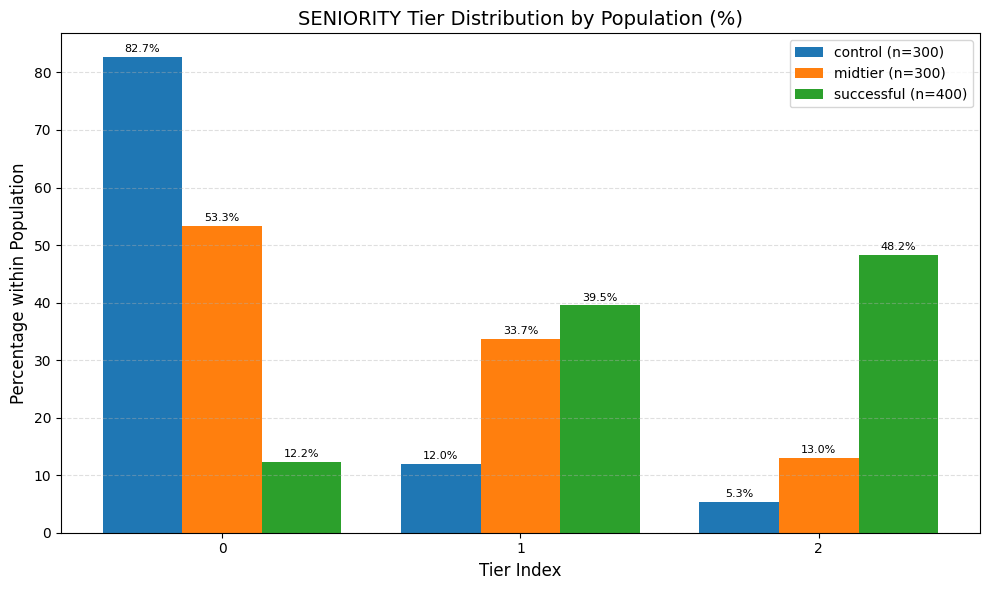

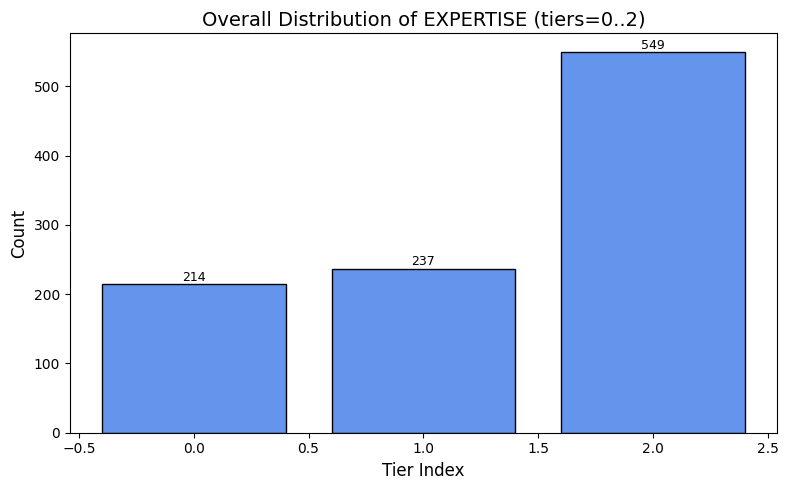

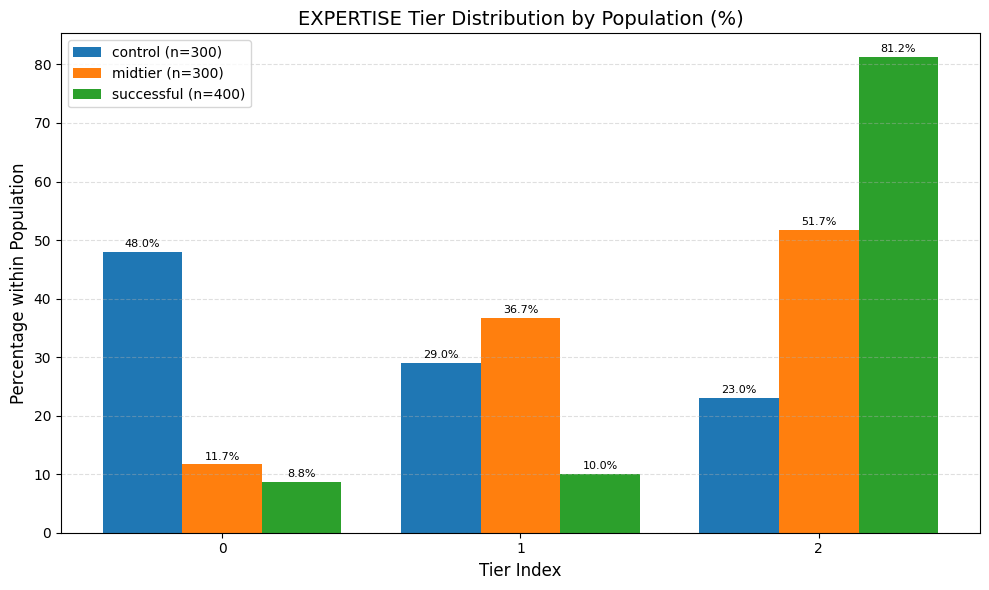

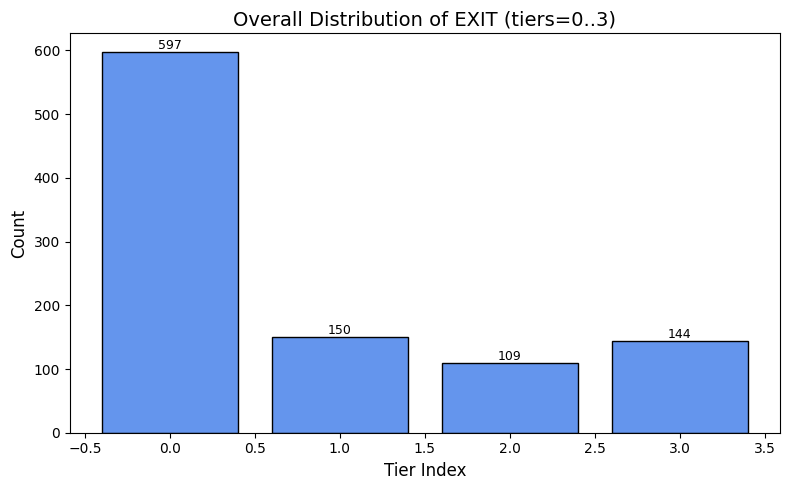

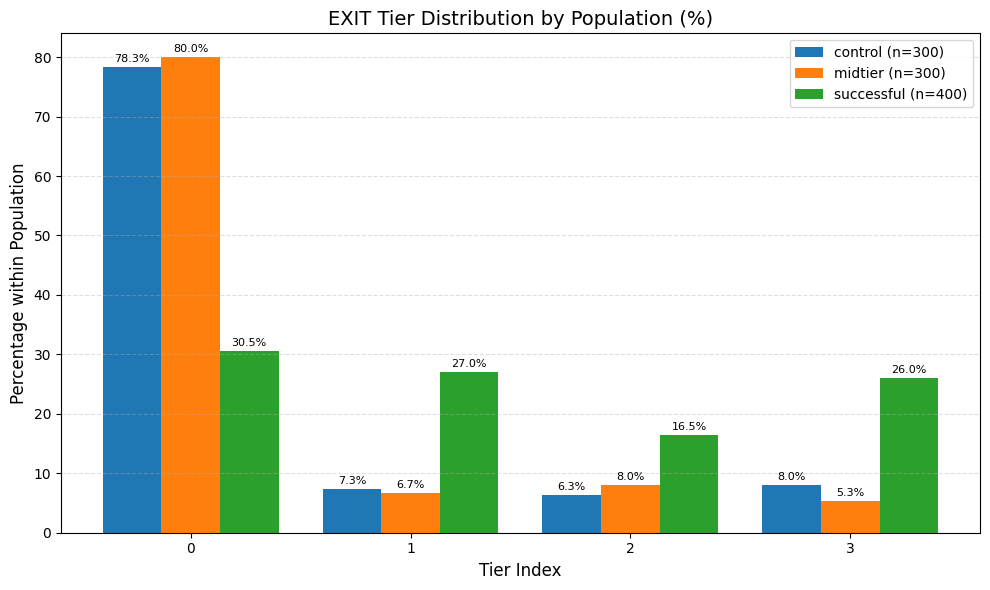

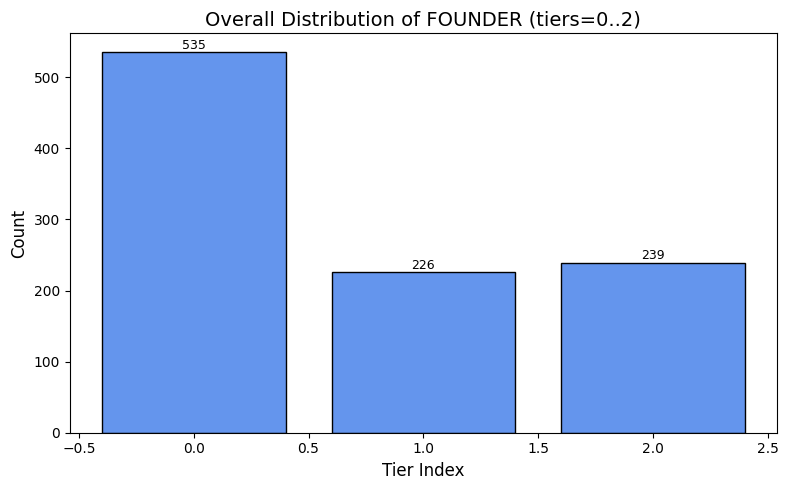

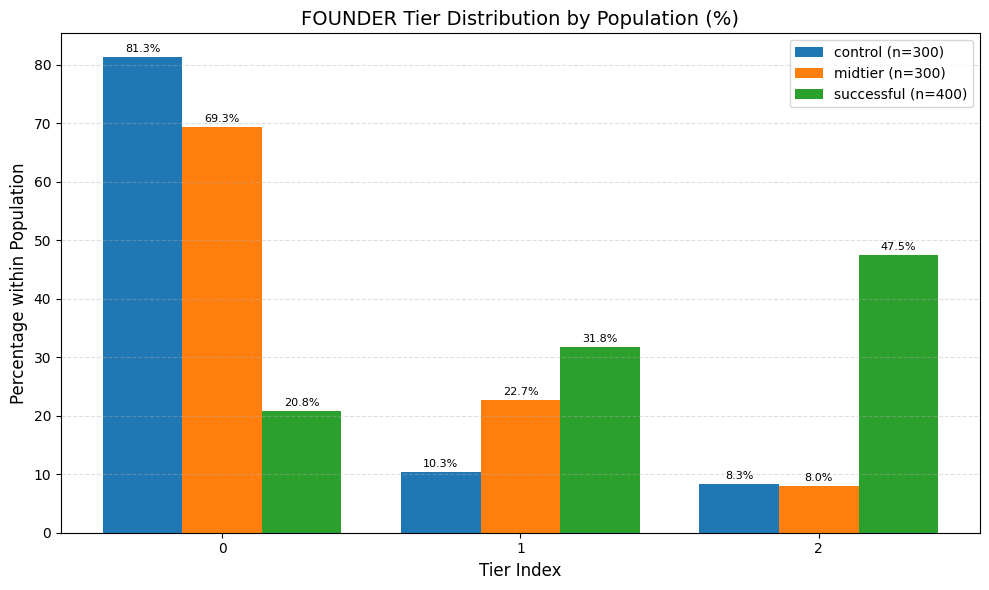

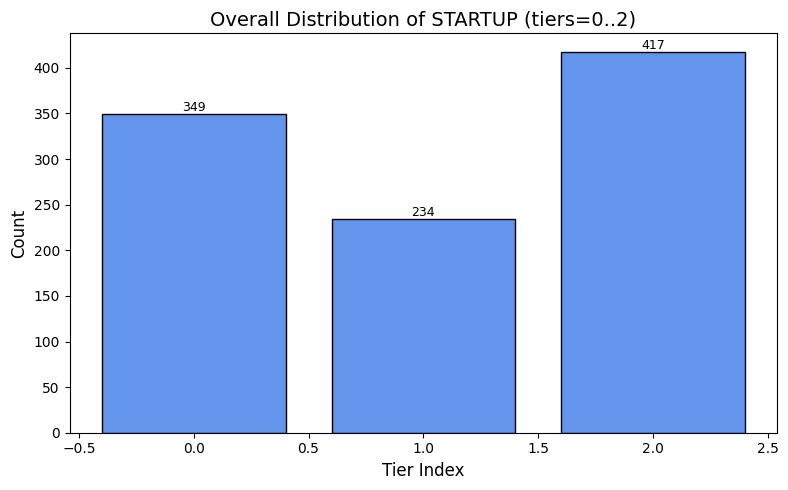

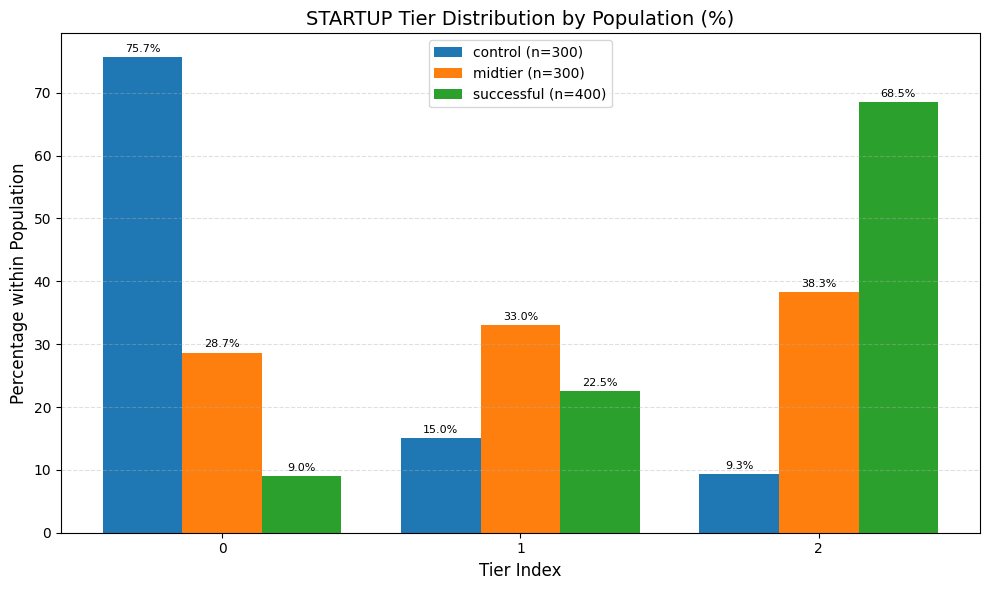

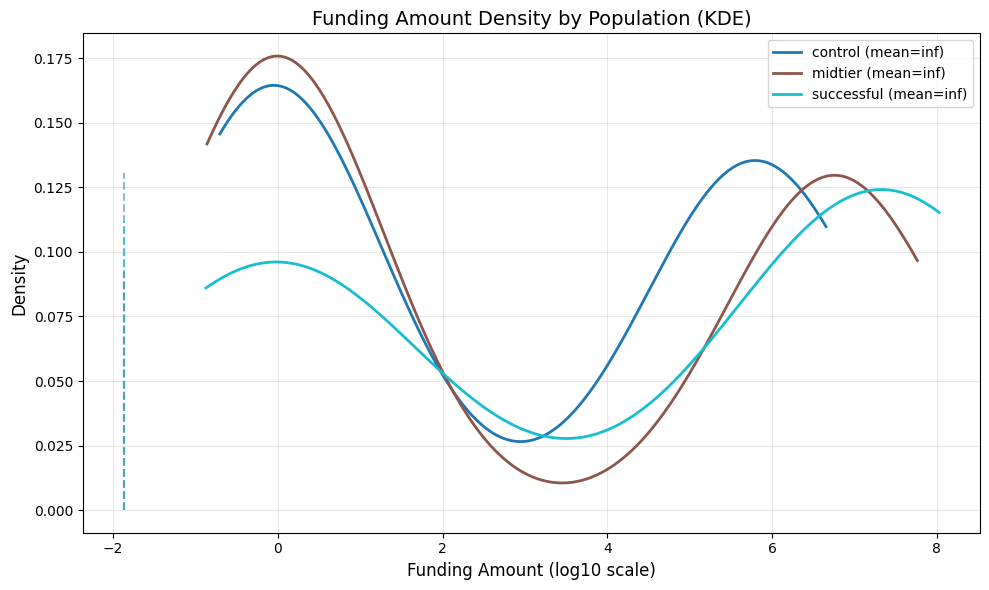

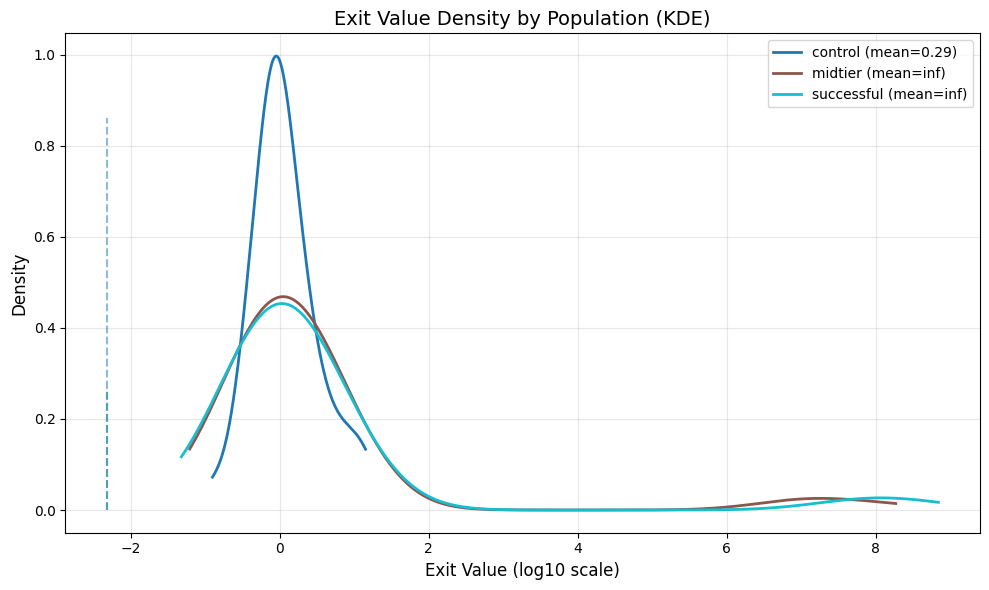

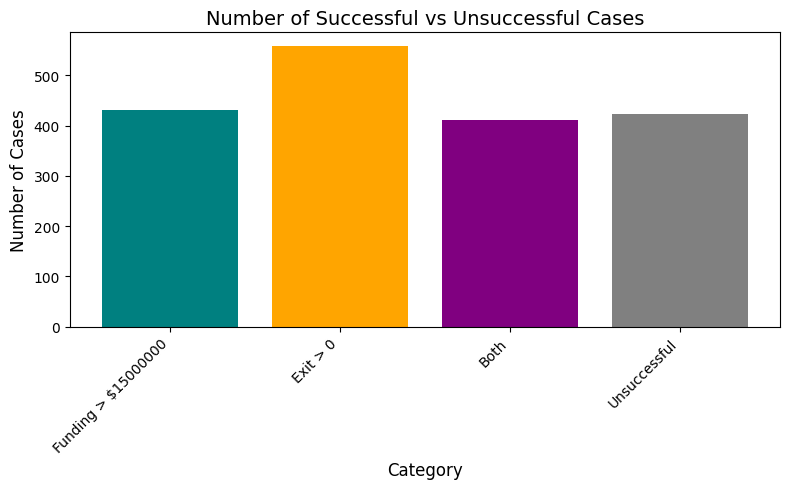

In [14]:
# plot
for cat_name in MATRIX.keys():
    plot_category_distribution_overall_and_by_pop(X_syn, pop_labels, cat_name)

plot_hist_overall_and_by_pop(fund_syn, pop_labels, title="Funding Amount", bins=50, log_scale=True)

plot_hist_overall_and_by_pop(exit_syn, pop_labels, title="Exit Value", bins=50, log_scale=True)

visualize_successful_cases(exit_syn, fund_syn)

In [15]:
df = dg.save_synthetic_dataset(
    X_syn, 
    exit_syn, 
    fund_syn, 
    MATRIX, 
    "../data/synth/encoded_founders_composites.csv", 
    success_funding_threshold=cfg.SUCCESS_FUNDING_THRESHOLD
)
df

,UNDERGRAD_1,UNDERGRAD_2,UNDERGRAD_3,GRADUATE_0,GRADUATE_1,GRADUATE_2,GRADUATE_3,COMPANY_1,COMPANY_2,COMPANY_3,...,EXIT_3,FOUNDER_1,FOUNDER_2,FOUNDER_3,STARTUP_1,STARTUP_2,STARTUP_3,exit_value,funding_amount,success
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,inf,inf,1
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,inf,inf,1
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,inf,inf,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,inf,inf,1
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,2.187148e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000e+00,0
996,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000e+00,0
997,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000e+00,0
998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000e+00,0



Basic Statistics:
Total samples: 1386

Samples per batch:
batch
S21              514
W21              465
top_companies    170
S17              123
W17              114
Name: count, dtype: int64

Success rate by batch:
batch
S17              0.479675
S21              0.198444
W17              0.421053
W21              0.286022
top_companies    0.958824
Name: success, dtype: float64


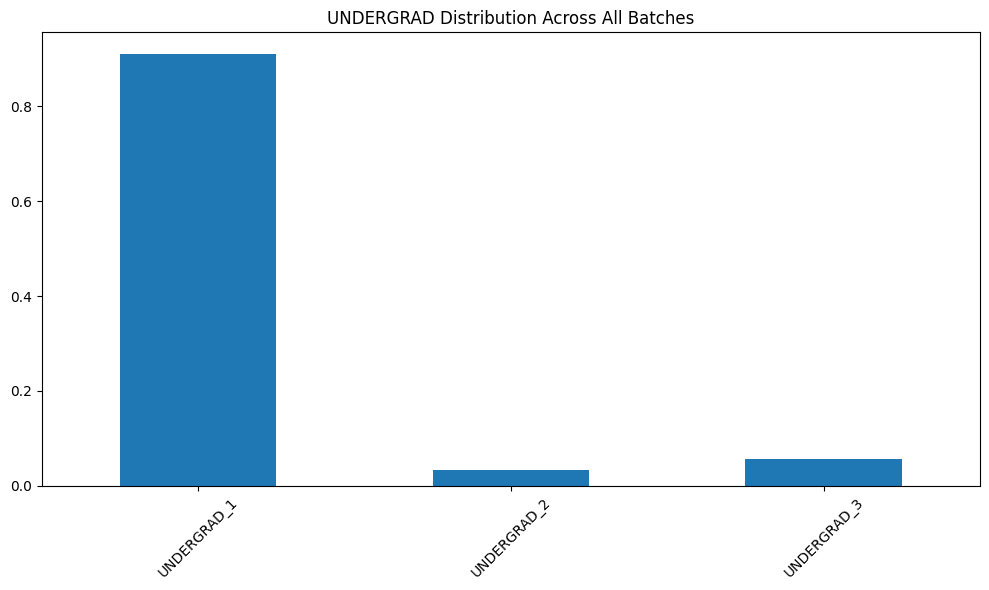

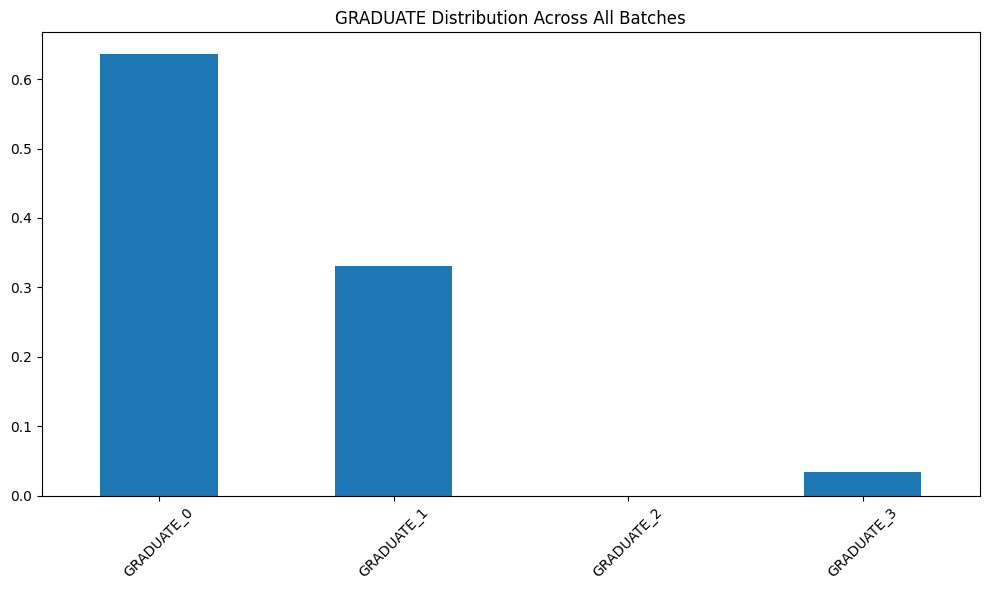

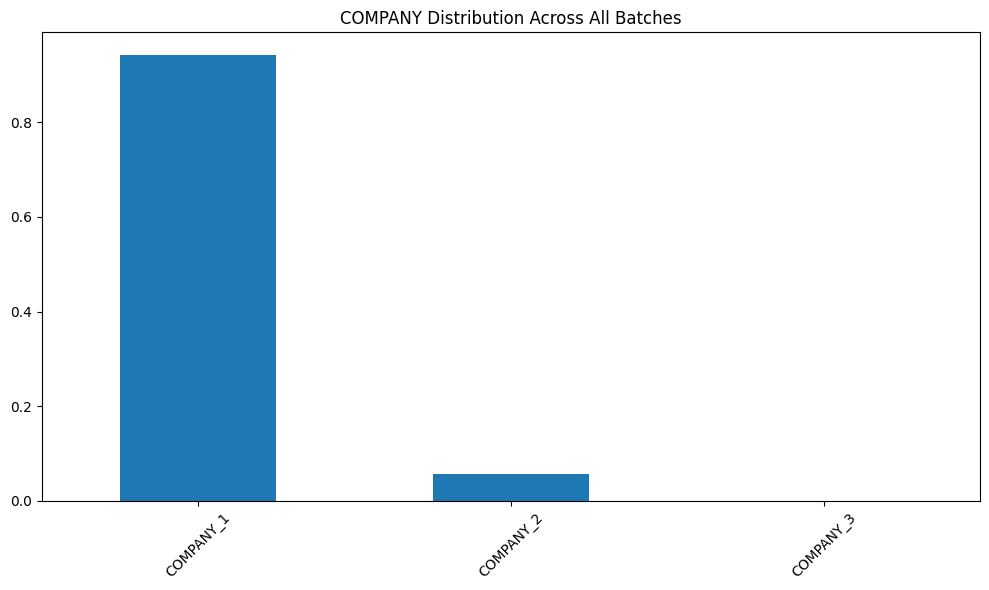

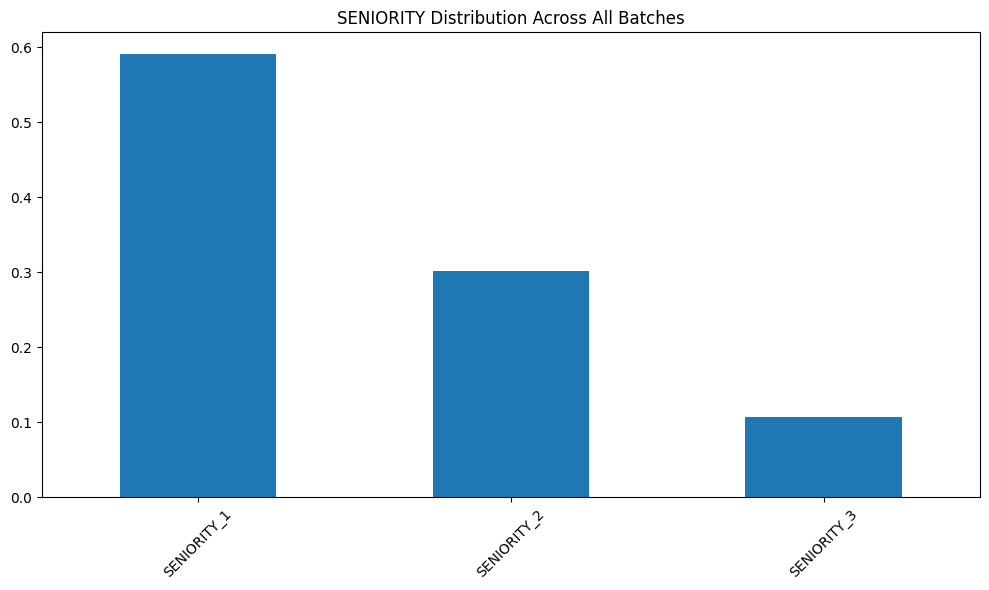

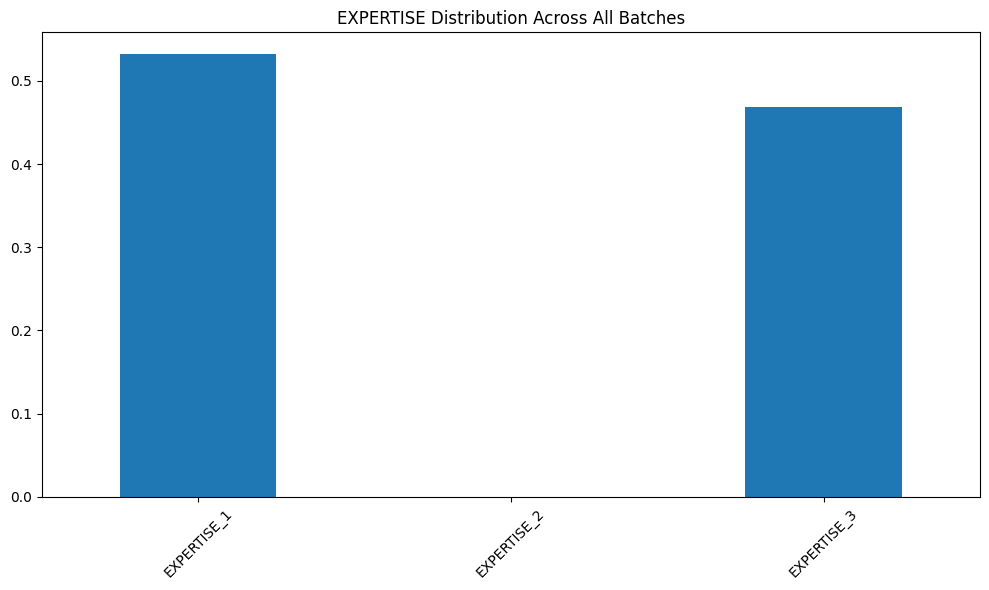

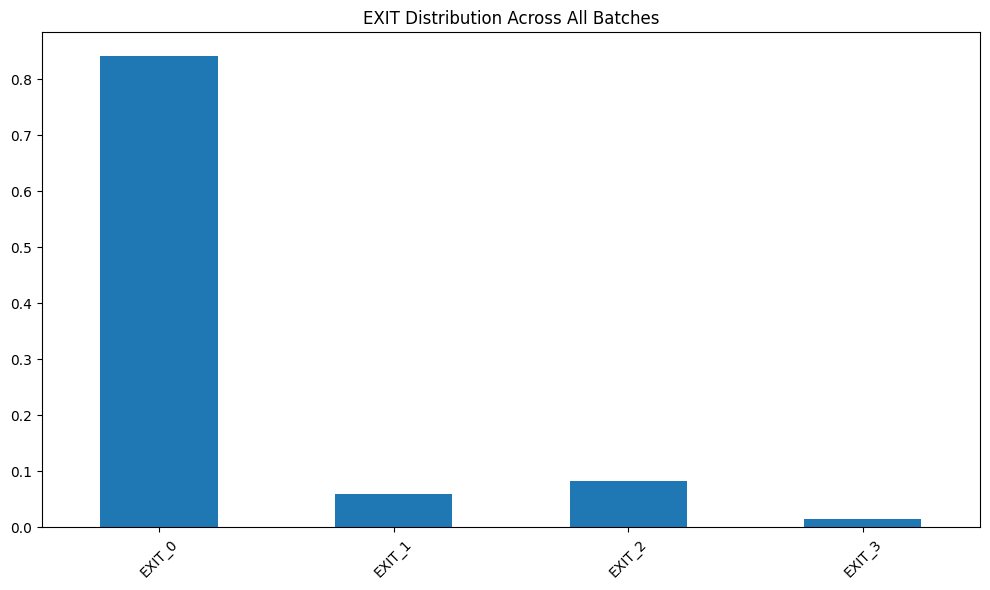

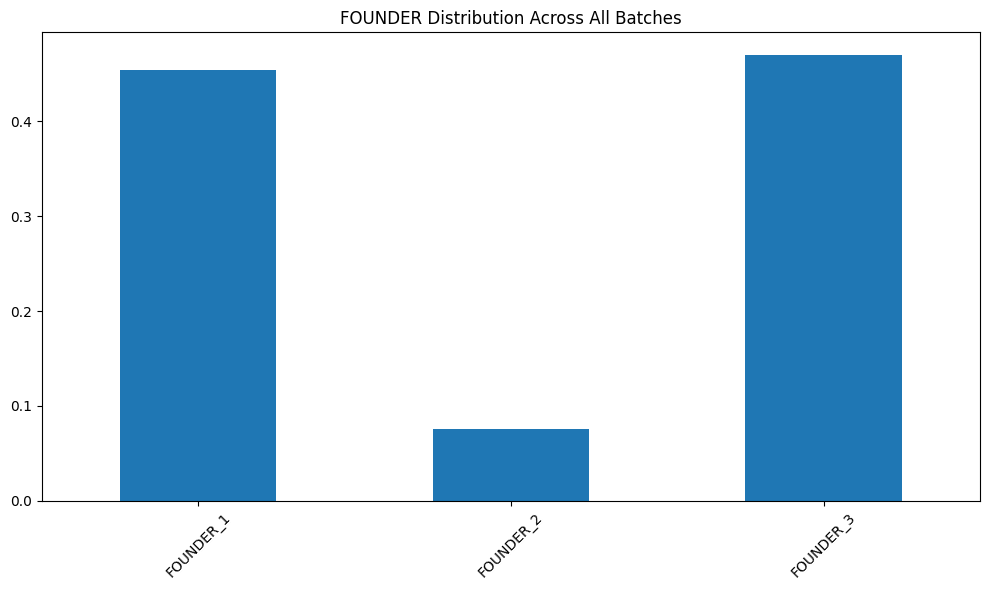

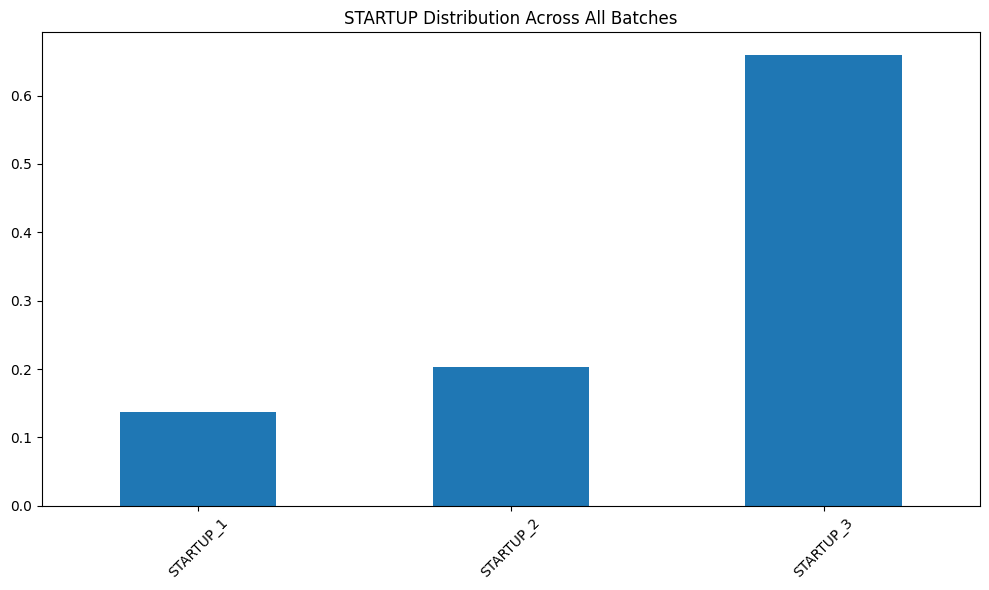

<Figure size 1000x600 with 0 Axes>

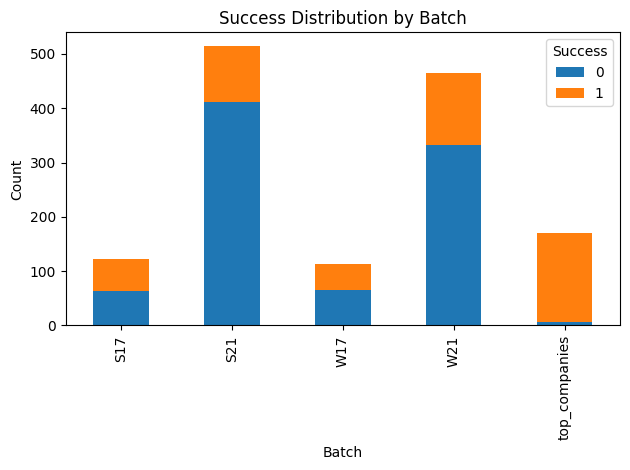

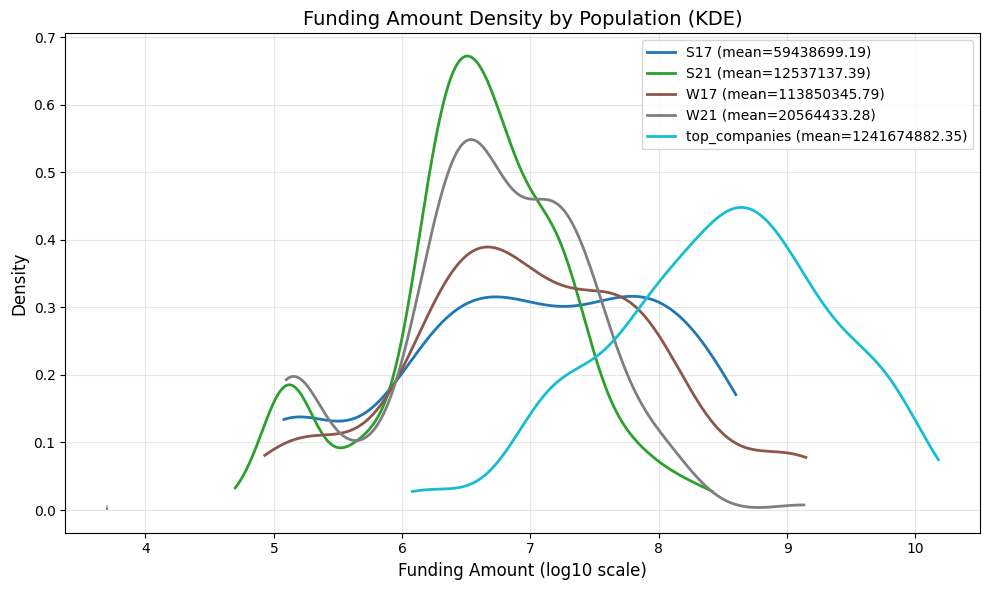

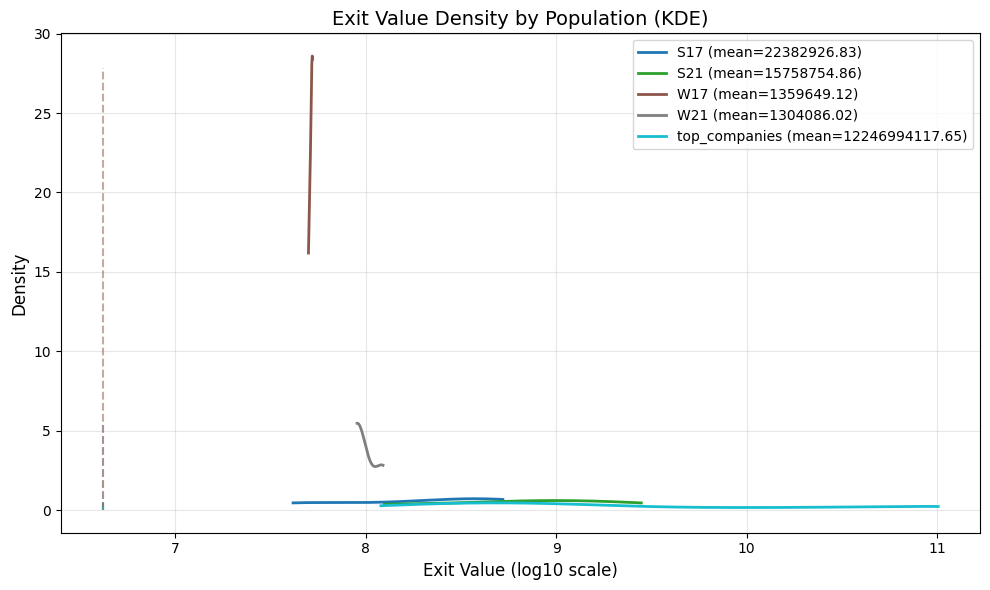

/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


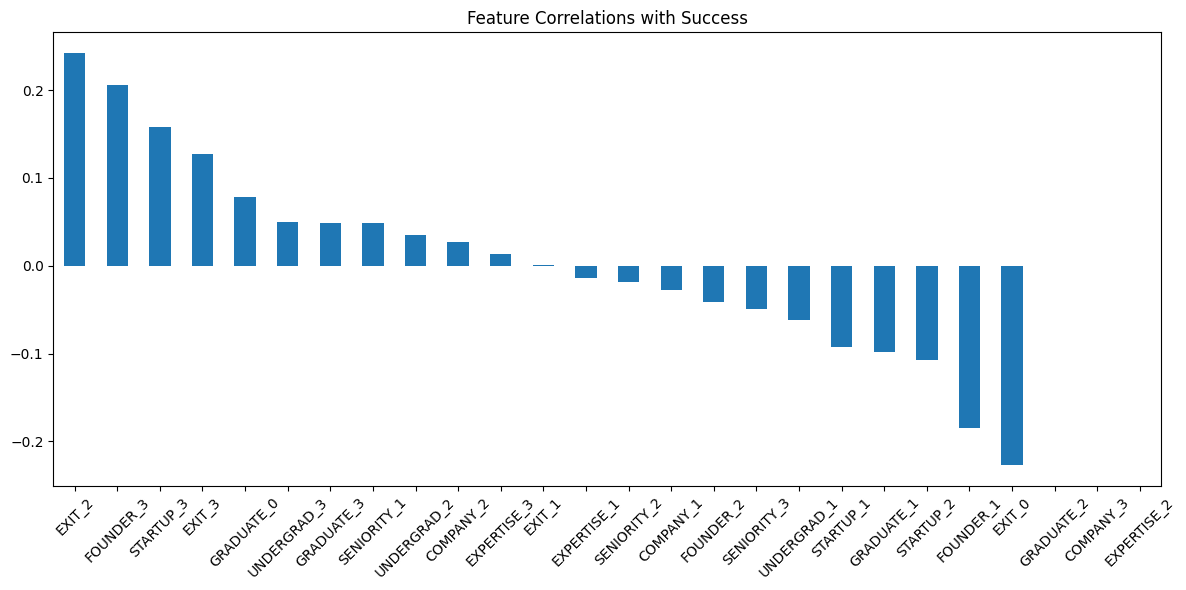

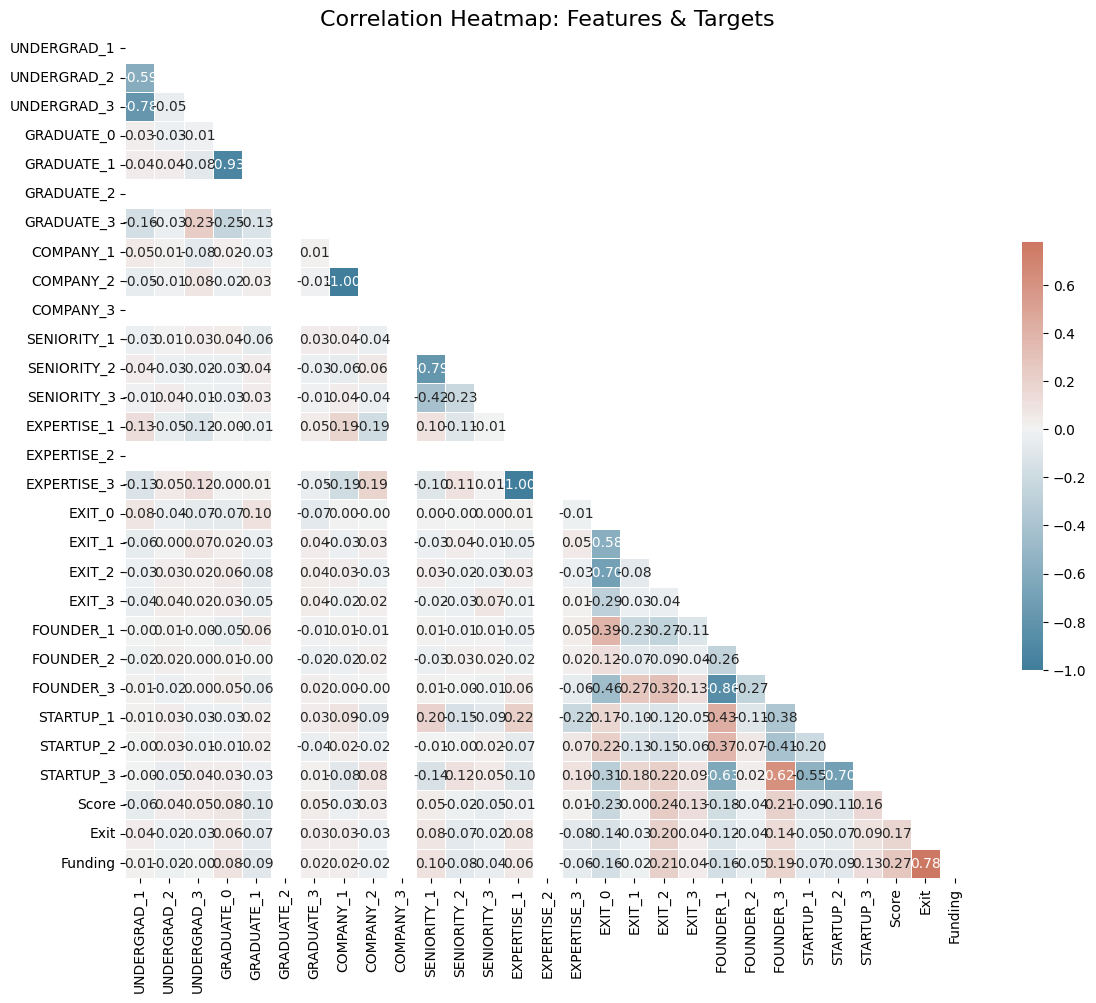

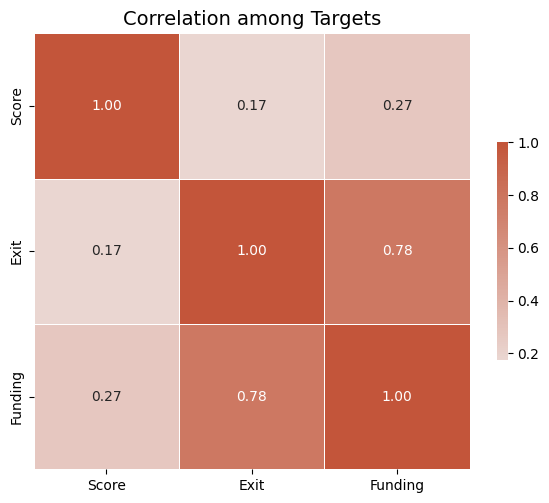

In [16]:
# Example usage with real YC batch data
batch_codes = ['S21', 'W21', 'S17', 'W17', 'top_companies']  # Add more batches as needed

def load_batch_data(batch_codes):
    """Load and combine data from specified YC batches"""
    data_dir = Path("../data/encoded")
    dfs = []
    
    for batch in batch_codes:
        file_path = data_dir / f"{batch}_encoded_with_outcomes.csv"
        if file_path.exists():
            df = pd.read_csv(file_path)
            df['batch'] = batch
            dfs.append(df)
        else:
            print(f"Warning: No data found for batch {batch}")
            
    if not dfs:
        raise ValueError("No data found for any specified batch")
        
    return pd.concat(dfs, ignore_index=True)

def analyze_batch_data(df, batch_codes):
    """Perform EDA on the combined batch data"""
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(f"Total samples: {len(df)}")
    print("\nSamples per batch:")
    print(df['batch'].value_counts())
    print("\nSuccess rate by batch:")
    print(df.groupby('batch')['success'].mean())
    
    # Feature distributions
    feature_cols = [col for col in df.columns if any(cat in col for cat in MATRIX.keys())]
    
    # Plot distributions for each category
    for cat in MATRIX:
        cat_cols = [col for col in feature_cols if cat in col]
        if cat_cols:
            plt.figure(figsize=(10, 6))
            df[cat_cols].mean().plot(kind='bar')
            plt.title(f"{cat} Distribution Across All Batches")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # Success analysis
    plt.figure(figsize=(10, 6))
    df.groupby(['batch', 'success']).size().unstack().plot(kind='bar', stacked=True)
    plt.title("Success Distribution by Batch")
    plt.xlabel("Batch")
    plt.ylabel("Count")
    plt.legend(title="Success")
    plt.tight_layout()
    plt.show()
    
    # Funding and exit analysis
    if 'funding_amount' in df.columns:
        plot_hist_overall_and_by_pop(
            df['funding_amount'].values,
            df['batch'].values,
            "Funding Amount",
            bins=30,
            log_scale=True
        )
    
    if 'exit_value' in df.columns:
        plot_hist_overall_and_by_pop(
            df['exit_value'].values,
            df['batch'].values,
            "Exit Value",
            bins=30,
            log_scale=True
        )
    
    # Feature importance for success
    feature_correlations = df[feature_cols].corrwith(df['success']).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    feature_correlations.plot(kind='bar')
    plt.title("Feature Correlations with Success")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plot_correlation_heatmap(
        df[feature_cols].values,
        df['success'].values,
        df['exit_value'].values,
        df['funding_amount'].values,
        feature_names=feature_cols
    )

# Load and analyze real data
df = load_batch_data(batch_codes)
analyze_batch_data(df, batch_codes)